# DBSCAN

**DBSCAN** is a clustering method that tries to identify and ignore outlier points that don't fit in well with any clusters. One of its big advantages is that it can create clusters of any shape, rather than preferring spherical blobs like $k$-means.

The algorithm has two hyperparameters: a neighborhood radius $\epsilon > 0$, and a minimum neighbor count $N_\text{min}$. DBSCAN defines a **core point** as a sample point that has at least $N_\text{min}$ additional samples within distance $\epsilon$ of it. Note that the relationship is not symmetric: the qualifying neighbors of a core point need not themselves be core points.

A cluster is defined as a core point, its $\epsilon$-neighborhood, and the neighborhoods of all core points in its neighborhood, etc., extended recursively. Points that are not core and that are not within the $\epsilon$-neighborhoods of any core points are designated as **noise points** and do not belong to any cluster.

If two points are in the same cluster, then one can be reached from the other entirely by hopping along through overlapping neighborhoods of core points. Since some points might be reachable from different clusters, however, the assignment to clusters can depend on the order in which the samples are processed. Otherwise, the outcome is deterministic.

Increasing $N_\text{min}$ helps to avoid having many small clusters, but it might also decrease the total number of core points. If the neighborhood radius $\epsilon$ is chosen too small, the algorithm is too picky—most points will end up as noise. If it's too large, then one tends to obtain a single mega-cluster. There are heuristics for trying to guess an optimal $\epsilon$, but it's frequently necessary to iterate over multiple values.[^optics]

[^optics]: The OPTICS algorithm attempts to address this issue by, in effect, analyzing the data just once for all $\epsilon$ simultaneously.

## Toy example

Here is a challenging artificial sample set: a blob of 200 points in the middle, with 300 points in a ring around it.

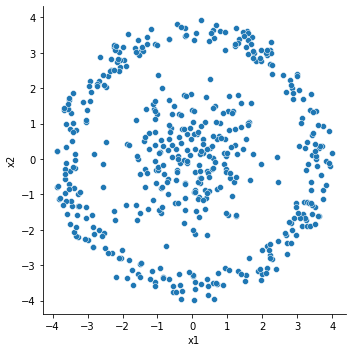

In [1]:
from numpy.random import default_rng
import numpy as np
import pandas as pd
import seaborn as sns

rng = default_rng(6)
inner = rng.normal(size=(200,2))
theta = rng.uniform(0,2*np.pi,size=300)
r = rng.uniform(3.2,4,size=300)
outer = np.vstack((r*np.cos(theta),r*np.sin(theta))).T

df = pd.DataFrame(np.vstack((inner,outer)),columns=["x1","x2"])
sns.relplot(data=df,x="x1",y="x2")

If we choose a small enough $\epsilon$, very few points have enough neighbors to qualify as core points, and most of the 500 points end up labeled as noise (value $-1$ as the cluster label).

In [2]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.02,min_samples=2)
db.fit(df)
y = pd.Series(db.labels_)
print(sum(y==-1),"noise points,",sum(y.unique()!=-1),"clusters")

488 noise points, 6 clusters


But if we make $\epsilon$ too large, everything is labeled as a single cluster.

In [3]:
db = DBSCAN(eps=1,min_samples=2)
db.fit(df)
y = pd.Series(db.labels_)
print(sum(y==-1),"noise points,",sum(y.unique()!=-1),"clusters")

0 noise points, 1 clusters


In between, most points belong to a cluster, and the number of clusters is pretty low.

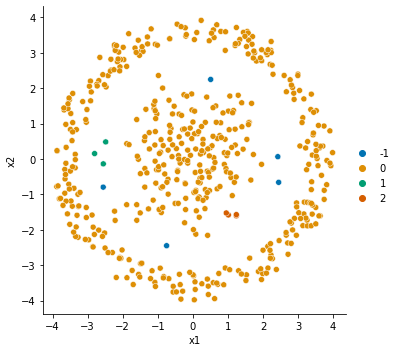

In [4]:
db = DBSCAN(eps=0.5,min_samples=2)
db.fit(df)
y = pd.Series(db.labels_)
sns.relplot(data=df,x="x1",y="x2",hue=y,palette="colorblind");

However, there is one very small cluster above that we can get rid of by adjusting $N_\text{min}$.

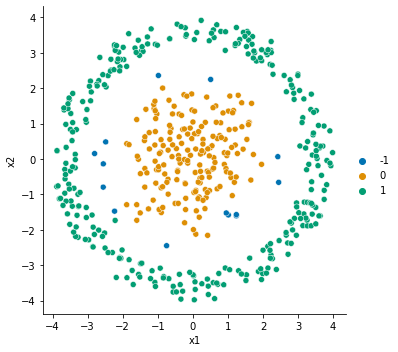

In [5]:
db = DBSCAN(eps=0.5,min_samples=5)
db.fit(df)
y = pd.Series(db.labels_)
sns.relplot(data=df,x="x1",y="x2",hue=y,palette="colorblind");

The two clusters are the natural ones, and the noise points arguably lie in no-man's-land.

## Digits

We return to the handwritten digits data, keeping only the written 4s, 5s, and 6s.

In [6]:
from sklearn import datasets
digits = datasets.load_digits(as_frame=True)["frame"]
X = digits.drop("target",axis=1)
y = digits.target
keep = (y==4) | (y==5) | (y==6)
X = X[keep]
y = y[keep]

Without a good sense for optimal hyperparameters, we do a quick search over $\epsilon$. We want to simulate not having any ground truth labels, so we will use the mean silhouette score to judge the clustering.

In [7]:
from sklearn.metrics import silhouette_score
result_ = []
eps_ = range(20,30)
for eps in eps_:
    dbs = DBSCAN(eps=eps,min_samples=4)
    dbs.fit(X)
    result_.append(silhouette_score(X,dbs.labels_))
    
best = np.argmax(result_)
print("best score is",result_[best],"at eps value",eps_[best])

best score is 0.22252976167954971 at eps value 23


Here's of the labels break down in the best case.

In [8]:
dbs = DBSCAN(eps=23,min_samples=4)
dbs.fit(X)
yhat = pd.Series(dbs.labels_,index=y.index)
yhat.value_counts()

 1    178
 0    170
 2    165
-1     31
dtype: int64

As you can see above, three clusters emerged naturally, which is encouraging. We can compare to the true labels via the Rand score:

In [9]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y,yhat)

0.908241730048358

This is a relatively easy classification problem, but nevertheless this is rather good performance for a method that has no prior no prior knowledge of the labels, or even how many classes there are. 

Let's take a look at some of the noise samples.

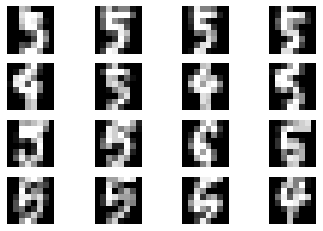

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_digits(X):
    fig, axes = plt.subplots(4,4)
    for i in range(4):
        for j in range(4):
            row = j + 4*i
            A = np.reshape(np.array(X.iloc[row,:]),(8,8))
            sns.heatmap(A,ax=axes[i,j],square=True,cmap="gray",cbar=False)
            axes[i,j].axis(False)
    return None

plot_digits(X[dbs.labels_==-1])

Some of these images are ambiguous at best, but in other cases the failure to be clustered with the rest of the class is harder to explain.